# Import libraries

In [51]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import tensorflow as tf

from keras import Model
from keras.models import Sequential

from keras.applications import resnet50, ResNet50
from tensorflow.keras.applications.efficientnet import EfficientNetB3, EfficientNetB0

from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.layers import BatchNormalization, Dropout
from tensorflow.keras.layers import Input, Activation, GlobalAveragePooling2D
from tensorflow.keras import layers

from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.metrics import Accuracy
from tensorflow.keras.metrics import F1Score

from tensorflow.keras.utils import plot_model, array_to_img
from tensorflow.keras.applications.imagenet_utils import decode_predictions
from sklearn.utils.class_weight import compute_class_weight

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

# Preprocessing
- Display the samples count of all classes.
- Get the shape of the images and the mode(RGB | BW | gray scale). [Extract Image Metadata](https://thepythoncode.com/article/extracting-image-metadata-in-python)
- Split the data into (train, test, validation)
- Display a sample of the data

Hail       -  591
Rainbow    -  232
Frost      -  475
Rime       -  1160
Fogsmog    -  851
Snow       -  621
Rain       -  526
Glaze      -  639
Lightning  -  377
Sandstorm  -  692
Dew        -  698


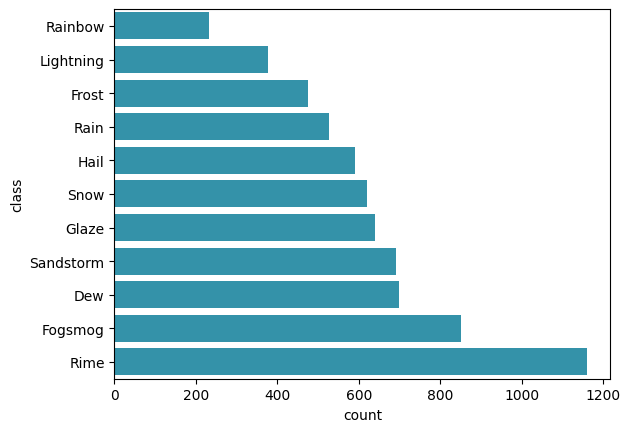

In [3]:
# Generate data paths with labels
data_dir = '/kaggle/input/weather-dataset/dataset'
filepaths = []
labels = []
sizes = []

folds = os.listdir(data_dir)
for fold in folds:
    foldpath = os.path.join(data_dir, fold)
    imglist = os.listdir(foldpath)
    
    labels.append(fold.title())
    sizes.append(len(imglist))
    
    print(f'{fold.title():10} - \033[92m {len(imglist)}\033[00m')
    
dist = {'class' : labels, 'count' : sizes}
dist = pd.DataFrame(dist).sort_values('count')

sns.barplot(data=dist, x="count", y='class', color='#219ebc');

In [4]:
from PIL import Image

In [5]:
def getImageInfo(img_path : str) -> None:
    # read the image data using PIL
    image = Image.open(img_path)
    
    # extract other basic metadata
    info_dict = {
        "Filename": image.filename,
        "Image Size": image.size,
        "Image Height": image.height,
        "Image Width": image.width,
        "Image Format": image.format,
        "Image Mode": image.mode,
    }
    
    print(f"{'Start':#^60s}")
    for label,value in info_dict.items():
        print(f"{label:25}: {value}")
    print(f"{'End':#^60s}\n")

In [6]:
getImageInfo('/kaggle/input/weather-dataset/dataset/rime/4930.jpg')
getImageInfo('/kaggle/input/weather-dataset/dataset/rime/4935.jpg')
getImageInfo('/kaggle/input/weather-dataset/dataset/rain/1011.jpg')
getImageInfo('/kaggle/input/weather-dataset/dataset/glaze/6090.jpg')

###########################Start############################
Filename                 : /kaggle/input/weather-dataset/dataset/rime/4930.jpg
Image Size               : (1200, 761)
Image Height             : 761
Image Width              : 1200
Image Format             : JPEG
Image Mode               : RGB
############################End#############################

###########################Start############################
Filename                 : /kaggle/input/weather-dataset/dataset/rime/4935.jpg
Image Size               : (412, 240)
Image Height             : 240
Image Width              : 412
Image Format             : JPEG
Image Mode               : RGB
############################End#############################

###########################Start############################
Filename                 : /kaggle/input/weather-dataset/dataset/rain/1011.jpg
Image Size               : (1125, 750)
Image Height             : 750
Image Width              : 1125
Image Format             :

## Data Loading and Generation
- Set a fixed random seed to make sure that we can replicate the same results.
- create a generator to load the data and augment it.
- Select the appropriate transformations for the data augmentaion.
- Assure to stratify the data to have a balanced training.


### Set Global Parameters

In [7]:
SEED = 42
IMG_SIZE = (224, 224)
# IMG_SIZE = (300, 300)
BATCH = 32
EPOCHS = 30

CHANNELS = 3
img_shape = (IMG_SIZE[0], IMG_SIZE[1], CHANNELS)
class_count = 11

In [8]:
np.random.seed(SEED)

In [9]:
train_datagen = ImageDataGenerator(rescale=1./255,
#                                rotation_range=20,
                               width_shift_range=0.1,
                               height_shift_range=0.1,
                               shear_range=0.1,
                               brightness_range=[1, 1.2],
                               zoom_range=0.1,
                               validation_split=0.15,
                               horizontal_flip=True)
    
test_datagen = ImageDataGenerator(
                            rescale=1./255.,
                            validation_split=.15
                            )


In [11]:
data_dir = '/kaggle/input/weather-dataset/dataset'

train_generator = train_datagen.flow_from_directory(
                                        directory=data_dir,
                                        target_size=IMG_SIZE,
                                        class_mode='categorical',
                                        subset='training',
                                        seed=SEED,
                                        batch_size=BATCH
                                    )

val_generator = test_datagen.flow_from_directory(
                                        directory=data_dir,
                                        target_size=IMG_SIZE,
                                        class_mode='categorical',
                                        subset='validation',
                                        seed=SEED,
                                        batch_size=BATCH
                                    )


Found 5839 images belonging to 11 classes.
Found 1023 images belonging to 11 classes.


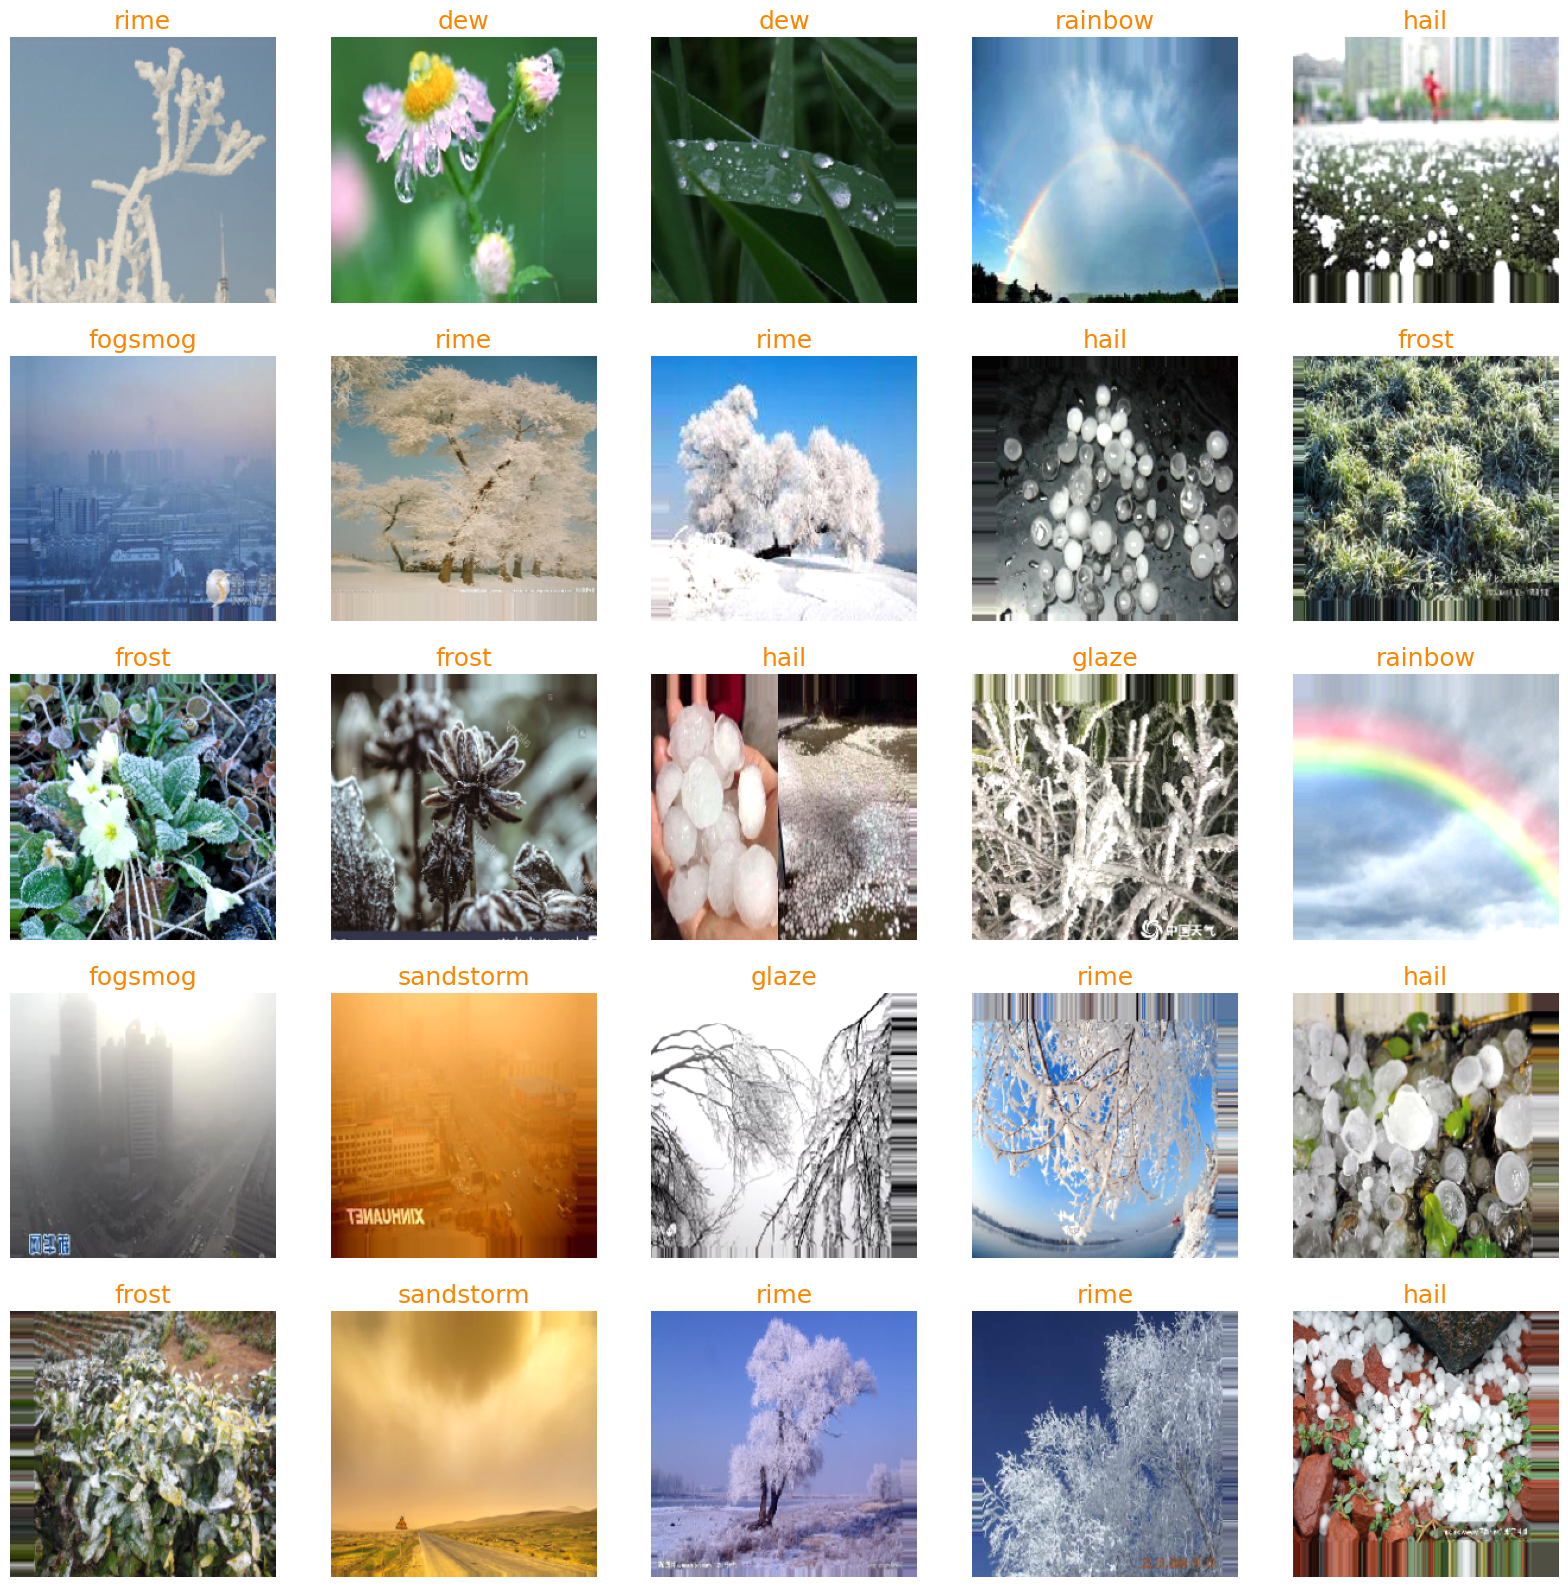

In [12]:
g_dict = train_generator.class_indices    # defines dictionary {'class': index}
classes = list(g_dict.keys())             # defines list of dictionary's kays (classes), classes names : string
images, labels_ = next(train_generator)   # get a batch size samples from the generator

# calculate number of displayed samples
length = len(labels_)        # length of batch size
sample = min(length, 25)    # check if sample less than 25 images

plt.figure(figsize= (20, 20))
for i in range(sample):
    plt.subplot(5, 5, i + 1)
    image = images[i]
    plt.imshow(image)
    index = np.argmax(labels_[i])  # get image index
    class_name = classes[index]   # get class of image
    plt.title(class_name, color= '#fb8500', fontsize= 18)
    plt.axis('off')
plt.show()

# Models

### Testing Base Model

In [16]:
base_model = ResNet50()
# base_model = EfficientNetB3()

pred = base_model.predict(val_generator)


 3/32 ━━━━━━━━━━━━━━━━━━━━ 2s 88ms/step

W0000 00:00:1714056561.226062     188 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


32/32 ━━━━━━━━━━━━━━━━━━━━ 11s 240ms/step


W0000 00:00:1714056568.673253     187 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


In [17]:
# pred.shape, 
print(pd.Series(pred.argmax(axis=-1)).value_counts())
decode_predictions(pred[:20], top=1)

111    1021
644       1
418       1
Name: count, dtype: int64


[[('n01930112', 'nematode', 0.15008293)],
 [('n01930112', 'nematode', 0.14957297)],
 [('n01930112', 'nematode', 0.14014658)],
 [('n01930112', 'nematode', 0.1487392)],
 [('n01930112', 'nematode', 0.1467612)],
 [('n01930112', 'nematode', 0.14219104)],
 [('n01930112', 'nematode', 0.14586684)],
 [('n01930112', 'nematode', 0.14449163)],
 [('n01930112', 'nematode', 0.07915671)],
 [('n01930112', 'nematode', 0.13465662)],
 [('n01930112', 'nematode', 0.14831276)],
 [('n01930112', 'nematode', 0.13697548)],
 [('n01930112', 'nematode', 0.14507459)],
 [('n01930112', 'nematode', 0.13926037)],
 [('n01930112', 'nematode', 0.079947256)],
 [('n01930112', 'nematode', 0.1455434)],
 [('n01930112', 'nematode', 0.14436619)],
 [('n01930112', 'nematode', 0.14775872)],
 [('n01930112', 'nematode', 0.13830447)],
 [('n01930112', 'nematode', 0.13817544)]]

As we see in the output of the base model it predicted all images as kite, which usually is flying in the sky... This like a naive understanding for the base model for our data..

In [43]:
base_model = EfficientNetB3(include_top= False, weights= "imagenet", 
                            input_shape= img_shape, pooling= 'avg')
# base_model = ResNet50(include_top= False, weights= "imagenet", 
#                             input_shape= img_shape, 
#                       pooling= 'avg'
#                      )

for layer in base_model.layers:
    layer.trainable = True
#     layer.trainable = False


model = Sequential([
    base_model,
    BatchNormalization(),
    Dense(256, 
#           kernel_regularizer= regularizers.l2(l= 0.016), activity_regularizer= regularizers.l1(0.006),
#                 bias_regularizer= regularizers.l1(0.006), 
          activation= 'relu'),
    Dropout(rate= 0.40, seed= SEED),
    Dense(class_count, activation= 'softmax')
])

model.compile(Adam(learning_rate= 0.001), loss= 'categorical_crossentropy', 
#                   metrics= [Accuracy(), F1Score(average='micro')])
                 metrics= ['accuracy'])
#                  metrics= ['accuracy', F1Score(average='micro')])


model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb3 (Functional)     │ ?                      │    10,783,535 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,783,535 (41.14 MB)

 Trainable params: 10,696,232 (40.80 MB)

 Non-trainable params: 87,303 (341.03 KB)

### Create class weight to handle imbalanced dataset

In [44]:
labels = list(train_generator.class_indices.values())
labels

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

In [45]:
y_labels = [[cls]*count for cls, count in zip(labels, sizes)]

flat_list = []

for xs in y_labels:
    for x in xs:
        flat_list.append(x)
y_labels = np.array(flat_list)
len(y_labels)        

6862

In [46]:
class_weights_values = compute_class_weight(class_weight="balanced", classes=labels, y=y_labels)

In [47]:
class_weights = {cls : w for cls, w in zip(labels, class_weights_values)}
class_weights

{0: 1.055529918474081,
 1: 2.688871473354232,
 2: 1.3133014354066985,
 3: 0.5377742946708464,
 4: 0.7330413417369939,
 5: 1.0045381349729177,
 6: 1.1859661251296232,
 7: 0.976241286100441,
 8: 1.6546901374487581,
 9: 0.9014713610089332,
 10: 0.8937223235217504}

### Model Training

In [61]:
history = model.fit(x= train_generator, epochs=EPOCHS, verbose= 1, 
#                     steps_per_epoch=train_generator.samples // BATCH,
                    validation_data= val_generator, 
#                     validation_steps= val_generator.samples // BATCH, 
                    class_weight=class_weights,
                    callbacks=[
                        EarlyStopping(patience=6, start_from_epoch=3, 
                                      restore_best_weights=True, verbose=1,
                                     ),
                        ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                              patience=4, min_lr=0.0001)
                    ],
                    shuffle= True)

Epoch 1/30
183/183 ━━━━━━━━━━━━━━━━━━━━ 99s 519ms/step - accuracy: 0.9772 - loss: 0.0809 - val_accuracy: 0.9228 - val_loss: 0.3638 - learning_rate: 2.5000e-04
Epoch 2/30
183/183 ━━━━━━━━━━━━━━━━━━━━ 93s 487ms/step - accuracy: 0.9807 - loss: 0.0581 - val_accuracy: 0.9110 - val_loss: 0.4695 - learning_rate: 2.5000e-04
Epoch 3/30
183/183 ━━━━━━━━━━━━━━━━━━━━ 94s 492ms/step - accuracy: 0.9814 - loss: 0.0610 - val_accuracy: 0.9022 - val_loss: 0.5330 - learning_rate: 2.5000e-04
Epoch 4/30
183/183 ━━━━━━━━━━━━━━━━━━━━ 97s 512ms/step - accuracy: 0.9846 - loss: 0.0446 - val_accuracy: 0.9179 - val_loss: 0.4547 - learning_rate: 2.5000e-04
Epoch 5/30
183/183 ━━━━━━━━━━━━━━━━━━━━ 92s 486ms/step - accuracy: 0.9856 - loss: 0.0398 - val_accuracy: 0.9169 - val_loss: 0.4812 - learning_rate: 2.5000e-04
Epoch 6/30
183/183 ━━━━━━━━━━━━━━━━━━━━ 92s 485ms/step - accuracy: 0.9911 - loss: 0.0260 - val_accuracy: 0.9179 - val_loss: 0.4456 - learning_rate: 1.2500e-04
Epoch 7/30
183/183 ━━━━━━━━━━━━━━━━━━━━ 100s 5

We trained the model 3 times with the above paramters and we saved the models from each time the second traing got the best results (95% Training Acc, 92% Validation Acc). While the third time the model was overfitting.

In [60]:
model.save('model_eff_----test.keras')

### Visualize Results

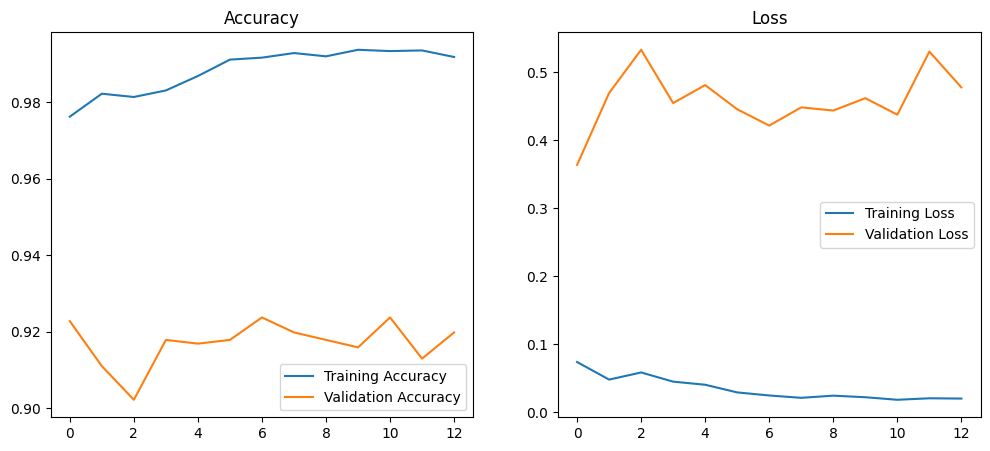

In [62]:
def visualize(history):
    fig , (ax1, ax2) = plt.subplots(1, 2)
    # fig.sub_title("NN Performance")
    fig.set_size_inches(12, 5)
    ax1.plot(history.history['accuracy'], label="Training Accuracy")
    ax1.plot(history.history['val_accuracy'], label="Validation Accuracy")
    ax1.set_title("Accuracy")
    ax1.legend()

    ax2.plot(history.history['loss'], label="Training Loss")
    ax2.plot(history.history['val_loss'], label="Validation Loss")
    ax2.set_title("Loss")
    ax2.legend()

    # plt.legend()

visualize(history)

---
## $$ ✨ The \space End✨$$